# Seizure Forecasting using Recurrent Neural Networks (RNN)

Here we use a network of gated recurrent units (GRU) to time-causally forecast seizures. <br>
As compared to what was done in the previous notebooks, there are two differences here: 
   1. We forecast seizures in patients that were not prevoiusly seen
   2. We only input counts of past seizures and past IEA and not the multidien phase directly. This is because, the calculation of the multidien phase is not time-causal, as it relies on future information through the use of the wavelet transform. 
   
   As a first step, however, we will demonstrate the use of the model directly on the phase of the multidien rhythms for a single patient, to show that it can reproduce the results obtained in the forecasting notebook with the generalized linear models (GLMs).  

## Import libraries

First we import basic Python libraries, as well as the widely used library of Tensorflow and Keras for training our neural networks.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
import tensorflow as tf
import keras
import os
import glob
import sys
from keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Model
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, Activation, GRU
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from pandas.plotting import register_matplotlib_converters
from keras.models import model_from_json

## Load the data

We first load the same raw data from the patient JE used previously.

In [2]:
data = pd.read_csv(r'data/features_day_JE_acausal4.csv')
data[['Time', 'Seizures', 'MultidienCos1', 'MultidienSin1']]

,Time,Seizures,MultidienCos1,MultidienSin1
0,733972.979167,0,0.509059,-0.860731
1,733973.979167,0,0.928224,-0.372022
2,733974.979167,2,0.986240,0.165321
3,733975.979167,0,0.771432,0.636311
4,733976.979167,0,0.348897,0.937161
...,...,...,...,...
535,734507.979167,1,0.632177,-0.774824
536,734508.979167,0,0.866598,-0.499006
537,734509.979167,0,0.983035,-0.183419
538,734510.979167,0,0.995309,0.096752


## Feature visualization

We will need to reorganize the features to input them into the GRUs. Let's first take another look at them.

<IPython.core.display.Javascript object>


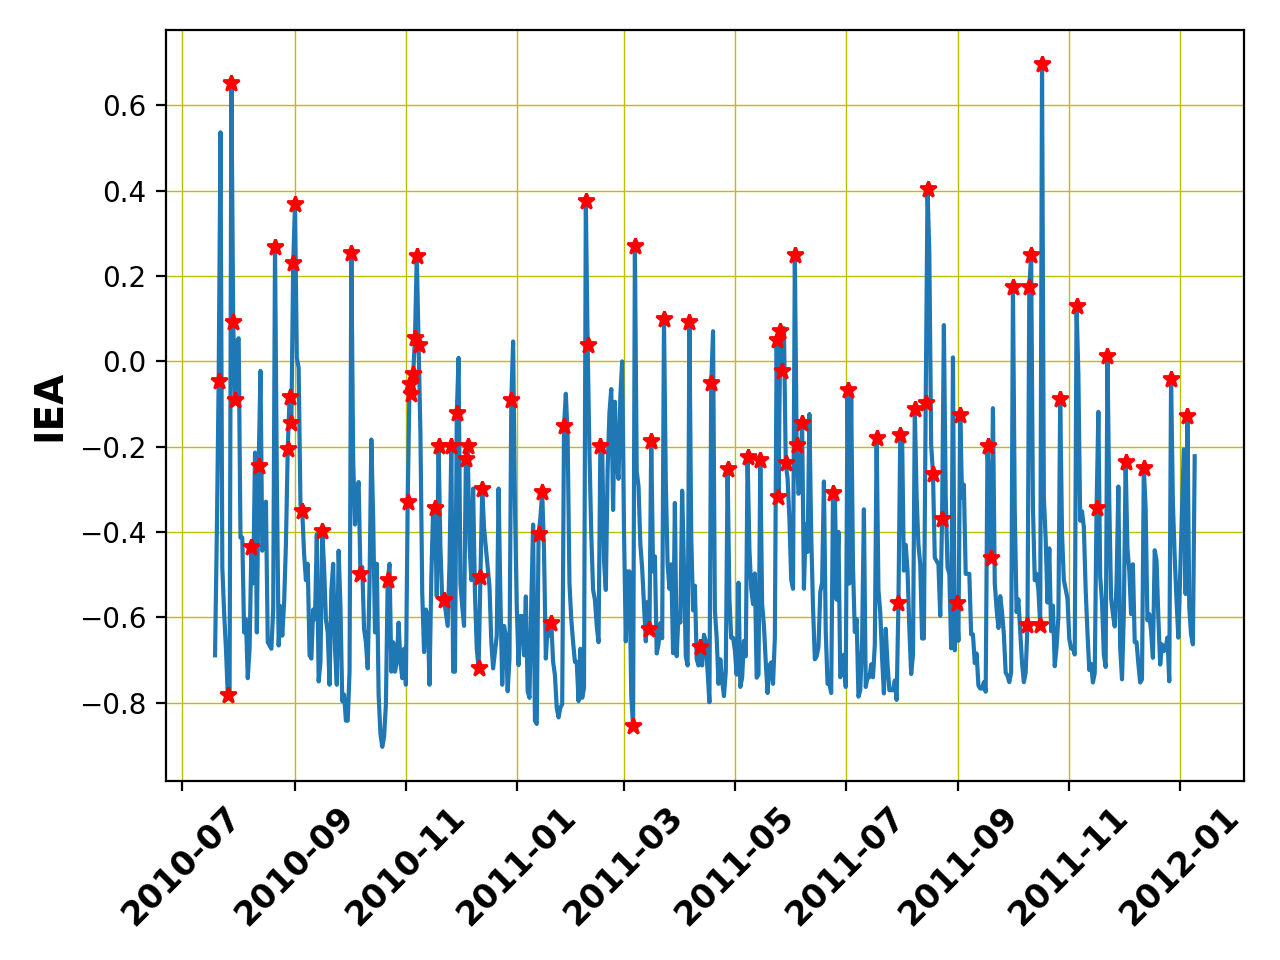

In [3]:
PosSeiz = np.where(data.Seizures>=1)
TimeDate = data.Time.astype(int).map(dt.datetime.fromordinal)
register_matplotlib_converters()

plt.figure()
plt.plot(TimeDate,data.IEA_1)
plt.plot(TimeDate.iloc[PosSeiz],data.IEA_1.iloc[PosSeiz],'r*')
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color='y', linewidth='0.5')
plt.tight_layout()
plt.show();

#### Figure
As seen in the first notebook, the figure shows the fluctuations of IEA (blue curve, averaged over one day) over time. We observe that IEA has a periodic behaviour. Use the interactive tools of the plot to display one year at a time, then only one month (zoom, empty square). You can travel on the x-axis using the directional cross. Seizures are plotted as red stars. The seizures tend to occur in the rising phase of IEA (i.e. when IEA increases over days). This is the strong relationship between the two features, we expect our network to learn. If it does, it will relie on changes in IEA to forecast the risk of seizure. 

## All patients together

Before doing anything, we put all our patients together since we will need as much as data as possible to train the network. First list all the data files:

In [4]:
Files=os.listdir('data')
check='f'
Files_csv = [idx for idx in Files if idx.lower().startswith(check.lower())]
Index_SS=Files_csv.index('features_day_SS_acausal4.csv')
Files_csv

['features_day_TC_acausal4.csv',
 'features_day_MM_acausal4.csv',
 'features_day_MR_acausal4.csv',
 'features_day_KH_acausal4.csv',
 'features_day_MF_acausal4.csv',
 'features_day_GK_acausal4.csv',
 'features_day_TV_acausal4.csv',
 'features_day_WP_acausal4.csv',
 'features_day_JC_acausal4.csv',
 'features_day_BJ_acausal4.csv',
 'features_day_JE_acausal4.csv',
 'features_day_EJ_acausal4.csv',
 'features_day_SS_acausal4.csv',
 'features_day_DP_acausal4.csv',
 'features_day_JW_acausal4.csv',
 'features_day_MQ_acausal4.csv',
 'features_day_GB_acausal4.csv',
 'features_day_KT_acausal4.csv']

Then load and concatenate all the data.

In [5]:
listsubjects=["BJ","DP","EJ","GB","GK","JC","JE","JW","KH","KT","MF","MM","MQ","MR","SS","TC","TV","WP"]

combined_csv = pd.concat([pd.read_csv(r'data/'+f) for f in Files_csv ],sort=True)
combined_csv[['Time', 'Seizures', 'MultidienCos1', 'MultidienSin1']]

,Time,Seizures,MultidienCos1,MultidienSin1
0,734055.979167,8,0.384246,-0.923231
1,734056.979167,2,0.831336,-0.555770
2,734057.979167,0,0.995815,-0.091392
3,734058.979167,0,0.934015,0.357233
4,734059.979167,7,0.701299,0.712867
...,...,...,...,...
485,737551.979167,1,0.941290,-0.337599
486,737552.979167,0,0.996546,-0.083038
487,737553.979167,0,0.984014,0.178092
488,737554.979167,0,0.905360,0.424644


## Input data organization


We organize the data such that we take past events for forecasting. Based on the rationale that multidien cycles were found up to 45 days, we take 60 days of data as input time-series to fully capture multidien cycles. 

We first find the initial position for each subject in our data:

In [6]:
StartSubj = np.where(combined_csv.index == 0)
StartSubj = StartSubj[0]
print(StartSubj)

[   0  451 1500 1874 2101 2547 3418 3831 4772 5210 5495 6035 6475 6764
 7150 7515 8199 8503]


Here we organize the data such that for each subject we take the past 60 days as features, with both the sin and cos of the phase.

In [7]:
NewStart = np.zeros(len(StartSubj)-1,dtype=int)
cosx, sinx, y = [], [], []
n_past=60
n_future=1
for j in range(len(StartSubj)-1):
    CosPhase = combined_csv.MultidienCos1[StartSubj[j]:StartSubj[j+1]].to_numpy()
    SinPhase = combined_csv.MultidienSin1.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    Seiz = combined_csv.Seizures.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    PosSeiz = np.where(Seiz>=1)
    Seiz[PosSeiz] = 1
    for i in range(0, len(Seiz)-n_past-n_future+1):
        cosx.append(CosPhase[i : i + n_past])
        sinx.append(SinPhase[i : i + n_past])
        y.append(Seiz[i + n_past : i + n_past + n_future])
    NewStart[j] = len(cosx)
    
cosx = np.array(cosx)
sinx = np.array(sinx)
x = np.stack((cosx,sinx),axis=2)
y = np.array(y)

We plot the cosine feature to see the how the data is now organized.

<IPython.core.display.Javascript object>


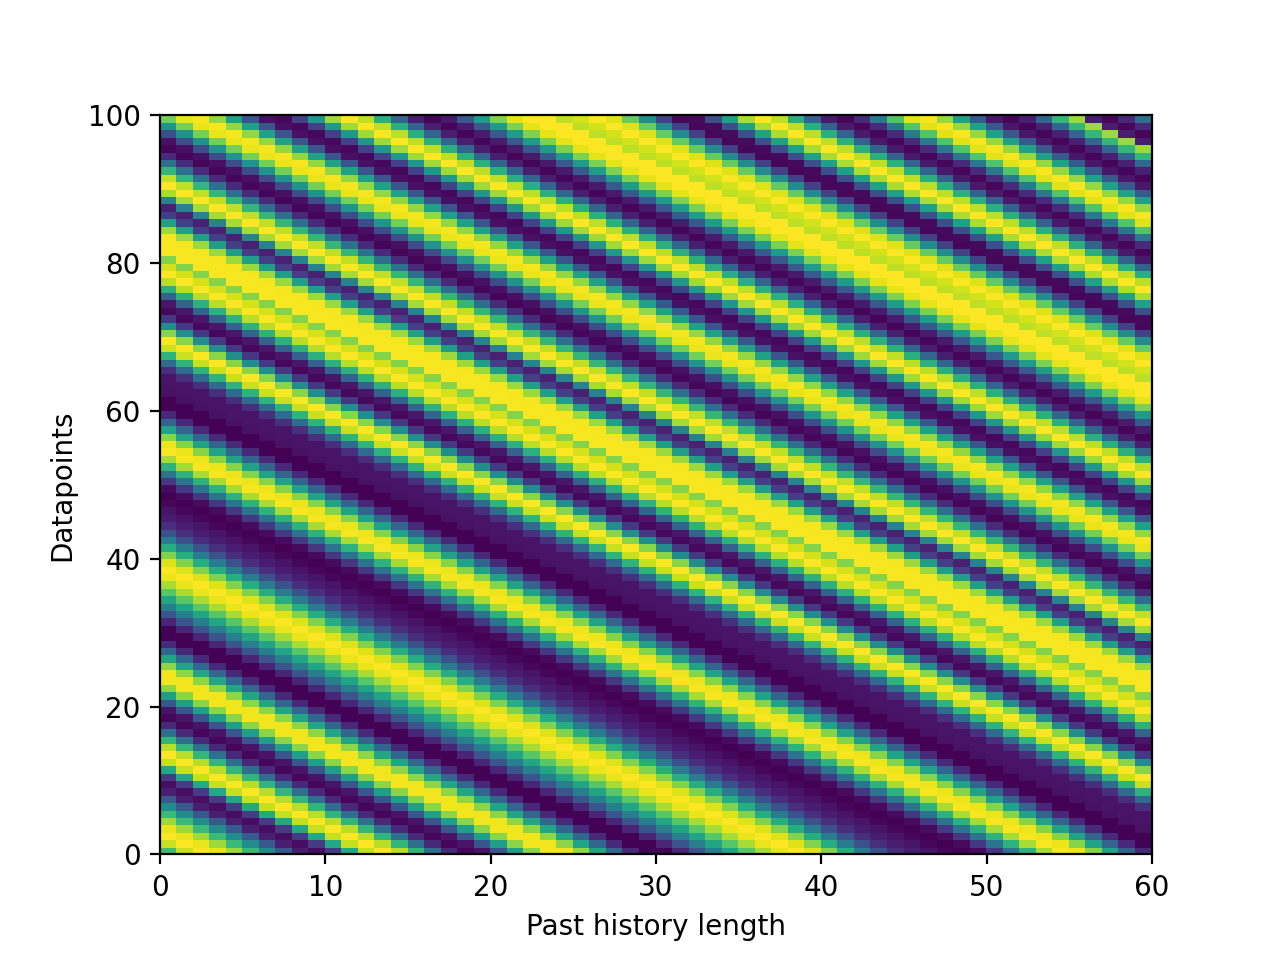

In [8]:
plt.figure()
plt.pcolormesh(cosx[:100,:])
plt.xlabel('Past history length')
plt.ylabel('Datapoints')
plt.show();

### GRU network

We will build a neural network with just one GRU layer. We use a sigmoid function as the activation function to have an output between 0 and 1 (i.e. a probability). 

We will use 10 GRU cells, and add a dropout layer with a rate of 20%, meaning that two cells will be discarded during each iteration of training.

In [9]:
keras.backend.clear_session()

# Input data as defined above
input_layer = Input(shape=(x.shape[1], 2), dtype='float32') 

# Single layer of gated recurrent units with 10 cells
Nodes = 10
GRUlayer = keras.layers.GRU(Nodes)(input_layer) 

# Droupout layer with rate set at 20%
dropout_layer = Dropout(0.2)(GRUlayer) 

# Output is matched to a range of 0 and 1 by a sigmoid function
output_layer = Dense(1,activation='sigmoid')(dropout_layer) 

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Define the loss function
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 2)]           0         
_________________________________________________________________
gru (GRU)                    (None, 10)                420       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


### Training on some patients and test on others

As we saw this morning, phases of the IEA rhythms and seizures are intrinsically related. For most patients, the seizures occur at the rising phase of the IEA.

Now, using a GRU, we want to test if our findings that generalize across patients as we saw using the PLV can also be applied for the forecasting of seizures. For this, we will use a subsets of patients to train the network, and other unseen patients to test them!

We fit the model with only some of the patients. Since it take some time, here we only use one epoch to illustrate the process.

In [10]:
NsubjTrain = 10
history = model.fit(x = x[:NewStart[NsubjTrain]], 
                    y = y[:NewStart[NsubjTrain]],
                    validation_split=0.15, 
                    batch_size=500, 
                    epochs=1, 
                    verbose=1, 
                    shuffle=False)

10/10 [==============================] - 2s 104ms/step - loss: 0.7167 - accuracy: 0.4194 - val_loss: 0.7133 - val_accuracy: 0.3445


### Predict on new patients

Here we use unseen data from other patients to test model.

In [11]:
y_pred = model.predict(x[NewStart[NsubjTrain]:])
y_test = y[NewStart[NsubjTrain]:]
StartTest = np.cumsum((np.ediff1d(NewStart[NsubjTrain:])))
StartTest = np.insert(StartTest, 0, 0, axis=0)
StartTest

array([   0,  380,  609,  935, 1240, 1864, 2108])

Plot the prediction for a single subject

<IPython.core.display.Javascript object>


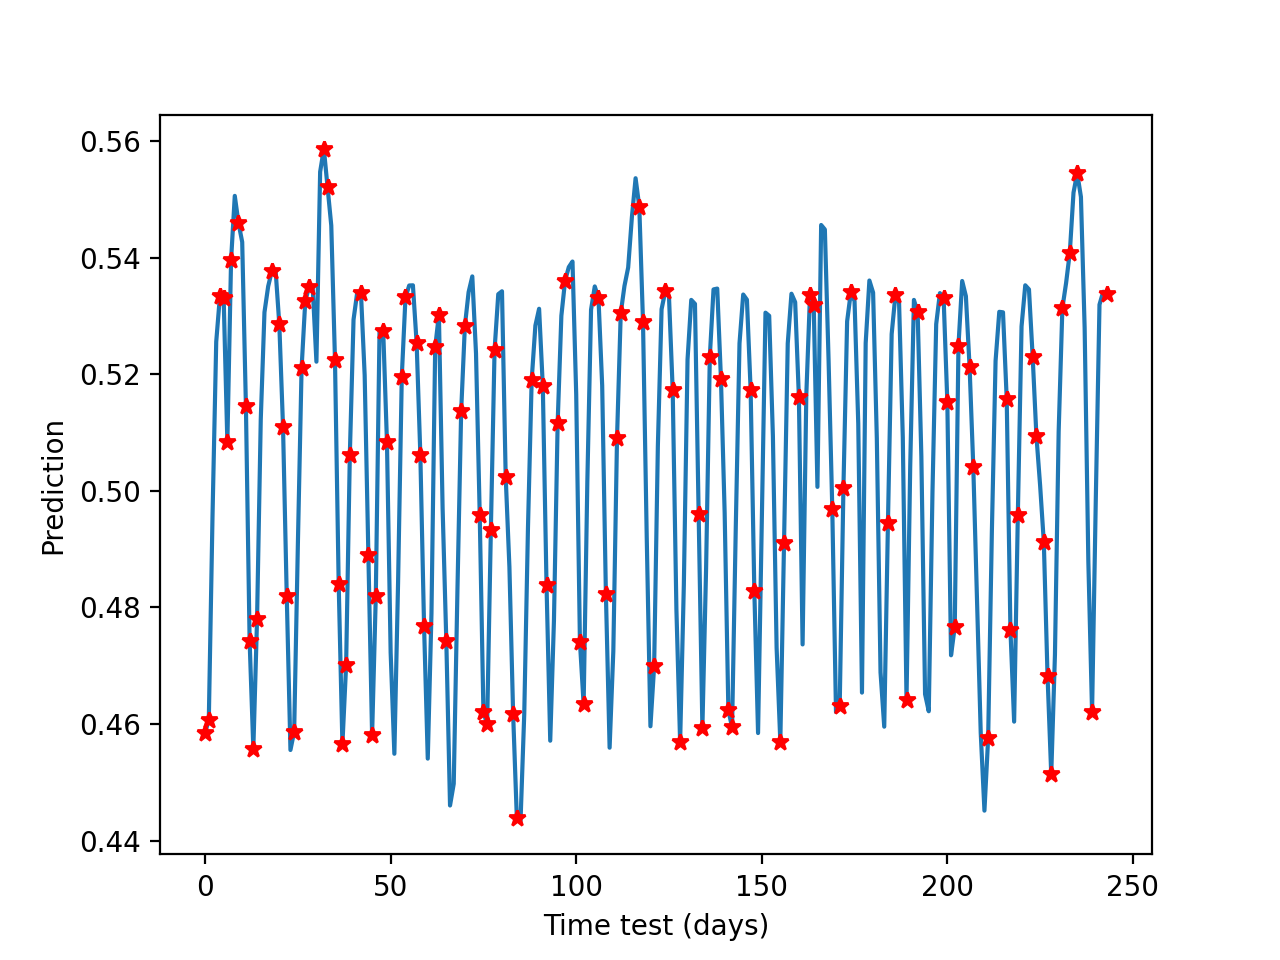

In [12]:
plt.figure()
pred_subject = y_pred[StartTest[5]:StartTest[6]]
seiz_subject = y_test[StartTest[5]:StartTest[6]]
plt.plot(pred_subject)
plt.plot(np.nonzero(seiz_subject)[0],pred_subject[seiz_subject==1],'r*')
plt.xlabel('Time test (days)')
plt.ylabel('Prediction')
plt.show();

**Figure** Prediction for a new patient using our GRU network

### Plot ROC curve for the test set

<IPython.core.display.Javascript object>


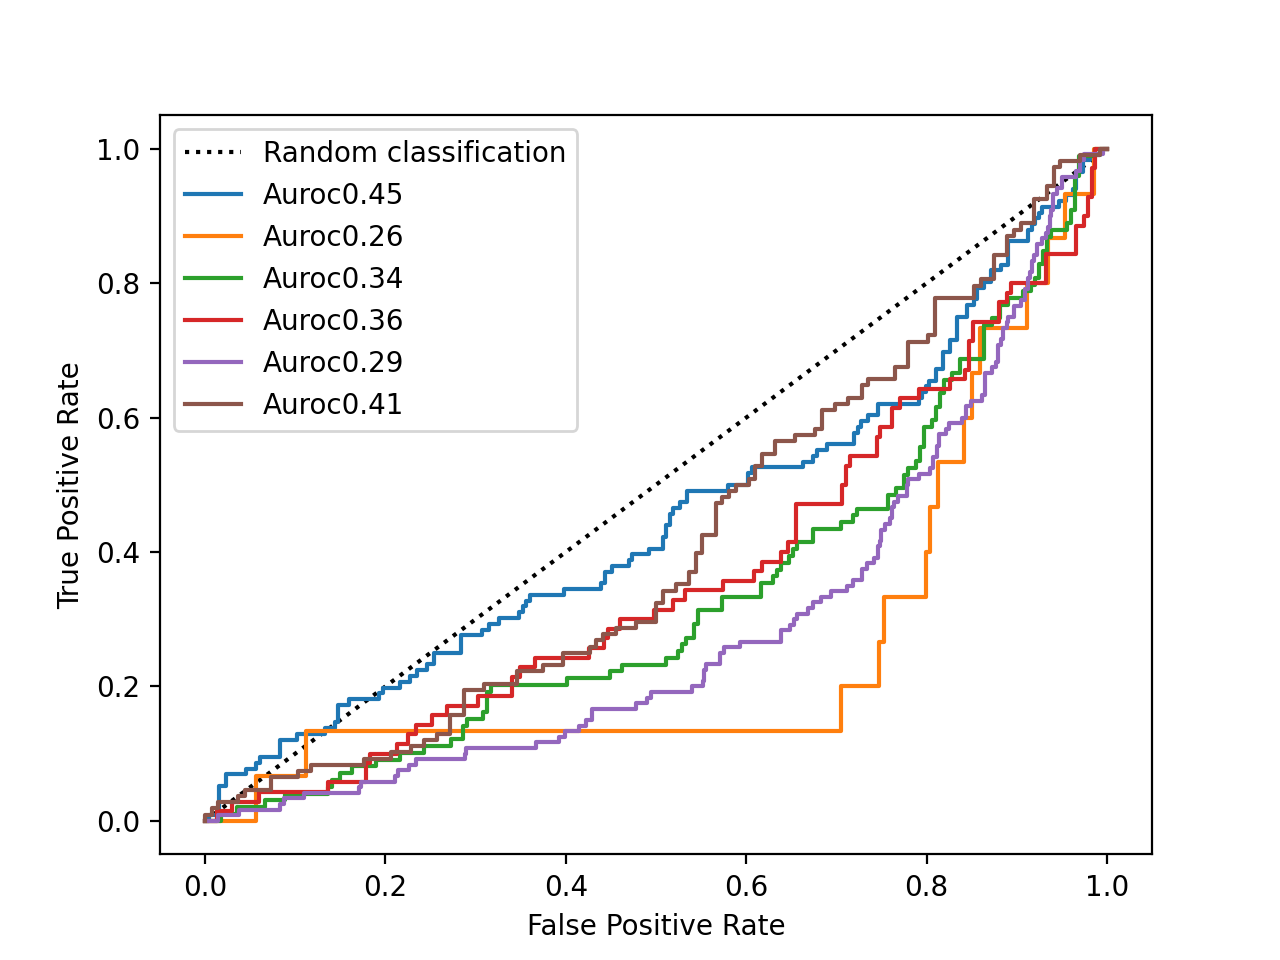

In [13]:
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Random classification")
for i in range(len(StartTest)-1):
    fpr, tpr, thresholds_keras = roc_curve(y_test[StartTest[i]:StartTest[i+1]],
                                           y_pred[StartTest[i]:StartTest[i+1]])
    auroc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='Auroc%0.2f' %auroc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

**Figure** We see that the results could be better, with only one epoch of trainning there is room from improvement

We load the the coefficient for the exact same model but trained on 30 epochs

In [14]:
keras.backend.clear_session()
name = ('Model_AMLD_Phasetd%.0fN%.0f.json' %(n_past,Nodes)) 
json_file = open( r'data/' + name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
    # load weights into new model                        
name2 = ('Model_weigth_AMLD_Phasetd%.0fN%.0f.h5' %(n_past,Nodes)) 
model.load_weights(r'data/' + name2)
print("Loaded model from disk")

Loaded model from disk


Predict the new patients with the loaded network

In [15]:
y_pred = model.predict(x[NewStart[NsubjTrain]:])
y_pred

array([[0.18967322],
       [0.1570696 ],
       [0.13512442],
       ...,
       [0.16099739],
       [0.15250635],
       [0.16740012]], dtype=float32)

Plot the ROC curves as before

<IPython.core.display.Javascript object>


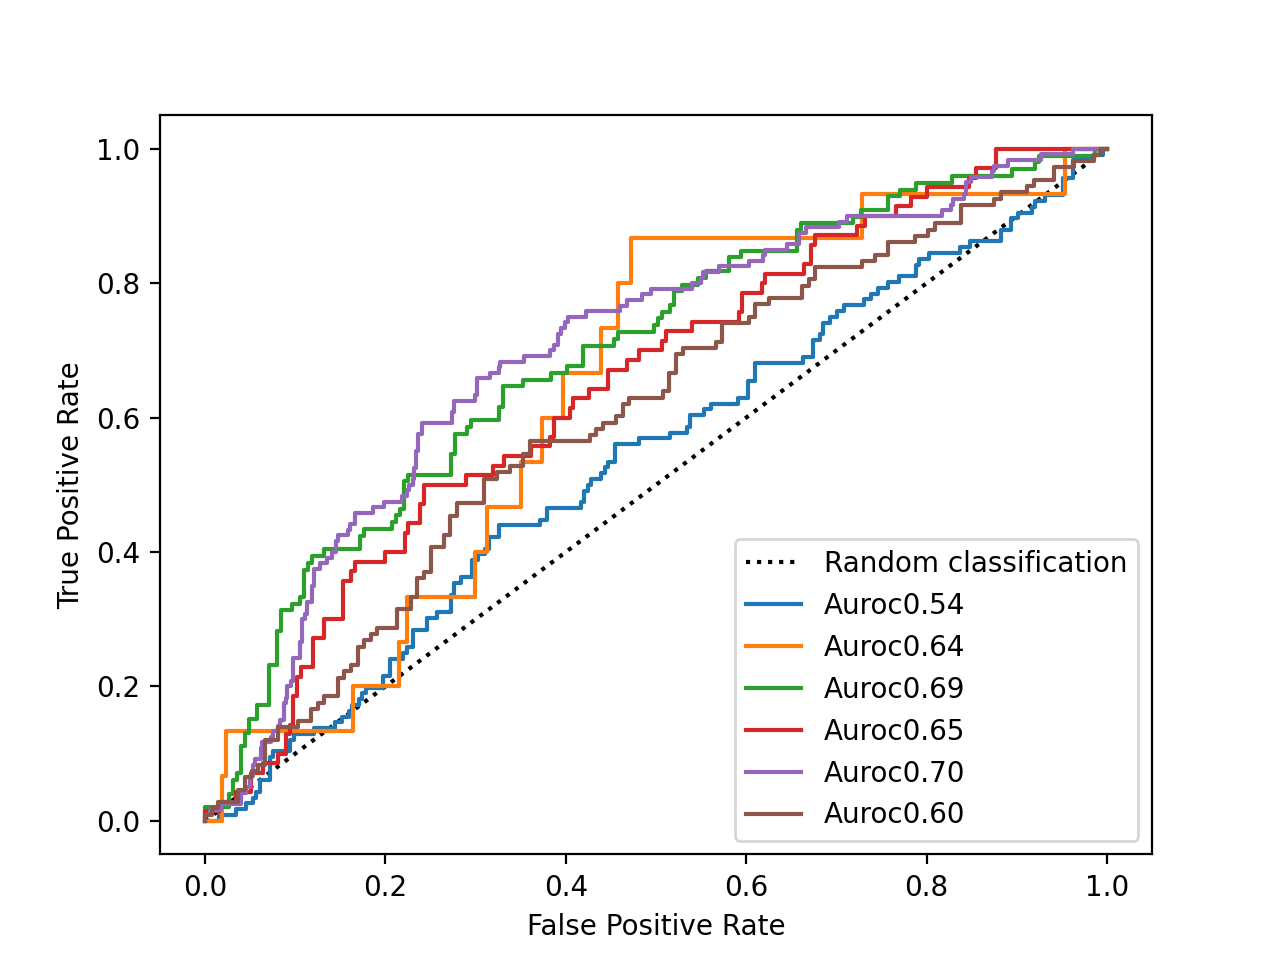

In [16]:
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Random classification")
for i in range(len(StartTest)-1):
    fpr, tpr, thresholds_keras = roc_curve(y_test[StartTest[i]:StartTest[i+1]], y_pred[StartTest[i]:StartTest[i+1]])
    auroc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='Auroc%0.2f' %auroc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

**Figure** The network is able to predict new patients without seeing without ever seeing that subject before!

We just showed that we can indeed predict the seizures for new patients only by the means of their multidien rhythm! However, to compute the phase using the wavelet, we implicitly take advantage of future information. This makes this method non-causal, since to compute the phase at time t, we are also using information at time t+1. However, for practical on-line application, we need our forecasts to be 100% causal, so that we can apply them in a prospective fashion.

### Causal forecasting using IEA and seizure history

One way to issue causal forecasts is to only take IEA counts and seizures as past information. 

As before we organize the data but now with IEA and seizures as features.

In [17]:
StartSubj = np.where(combined_csv.index == 0)
StartSubj = StartSubj[0]
print(StartSubj)
NewStart = np.zeros(len(StartSubj)-1,dtype=int)
x1, x2, y =[], [], []
n_past=60
n_future=1
for j in range(len(StartSubj)-1):
    if j==Index_SS:
        IEA = combined_csv.IEA.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    else:
        IEA = combined_csv.IEA_1.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    Seiz = combined_csv.Seizures.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    PosSeiz = np.where(Seiz>=1)
    Seiz[PosSeiz] = 1
    Seiz[np.isnan(Seiz)] = 0
    for i in range(0,len(Seiz)-n_past-n_future+1):
        x1.append(IEA[i : i + n_past])
        x2.append(Seiz[i : i + n_past])
        y.append(Seiz[i + n_past : i + n_past + n_future])
    NewStart[j]=len(x1)
    
x1 = np.array(x1)
x2 = np.array(x2)
x = np.stack((x1,x2),axis=2)
y = np.array(y).astype(int)

[   0  451 1500 1874 2101 2547 3418 3831 4772 5210 5495 6035 6475 6764
 7150 7515 8199 8503]


#### Load the model
We provide the model coefficients that we train on a larger cohort.

In [18]:
keras.backend.clear_session()
name = ('Model_AMLD_Seiz_IEAtd%.0fN%.0f.json' %(n_past,60)) 
json_file = open('data/' + name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
    # load weights into new model                        
name2 = ('Model_weigth_AMLD_Seiz_IEAtd%.0fN%.0f.h5' %(n_past,60)) 
model.load_weights('data/' + name2)
print("Loaded model from disk")

Loaded model from disk


Predict seizures for all patients

In [19]:
y_pred = model.predict(x)

#### Plot the ROC curves for the whole cohort provided

<IPython.core.display.Javascript object>


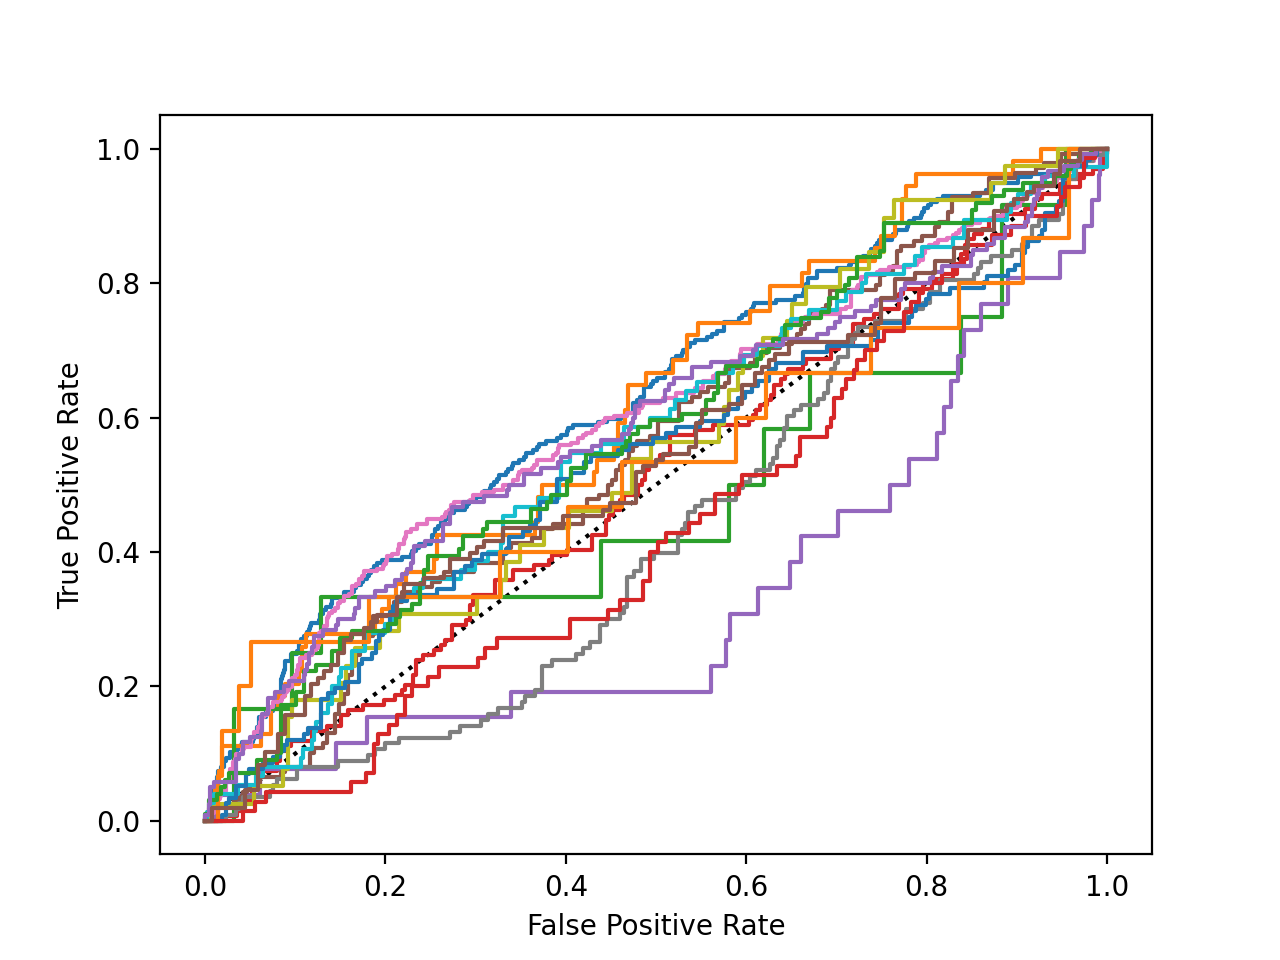

In [20]:
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Random classification")
for i in range(len(NewStart)-1):
    fpr, tpr, thresholds_keras = roc_curve(y[NewStart[i]:NewStart[i+1]], y_pred[NewStart[i]:NewStart[i+1]])
    auroc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='Auroc%0.2f' %auroc)
#plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

**Figure**: Most patients have AUC higher than chance, however we lose some performance compared when we use the cosine and sine of the phase of the multidien rhythms.  Keep in mind that we are now doing a fully causal forecasting, on new unseen patients, using only IEA and seizures history. From what we learned on the multidien rhythm, we thus see that there is still room from improvement.